__Probing Language Models__

This notebook serves as a start for your NLP2 assignment on probing Language Models. This notebook will become part of the contents that you will submit at the end, so make sure to keep your code (somewhat) clean :-)

__note__: This assignment is not dependent on big fancy GPUs. I run all this stuff on my own 3 year old CPU, without any Colab hassle. So it's up to you to decide how you want to run it.

# Models

For the Transformer models you are advised to make use of the `transformers` library of Huggingface: https://github.com/huggingface/transformers
Their library is well documented, and they provide great tools to easily load in pre-trained models.

In [1]:
#
## Your code for initializing the transformer model(s)
#
# Note that most transformer models use their own `tokenizer`, that should be loaded in as well.
#
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

C:\Users\zoepr\anaconda3\envs\nlp2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
#
## Your code for initializing the rnn model(s)
#
# The Gulordava LSTM model can be found here: 
# https://drive.google.com/file/d/19Lp3AM4NEPycp_IBgoHfLc_V456pmUom/view?usp=sharing
# You can read more about this model in the original paper here: https://arxiv.org/pdf/1803.11138.pdf
#
# N.B: I have altered the RNNModel code to only output the hidden states that you are interested in.
# If you want to do more experiments with this model you could have a look at the original code here:
# https://github.com/facebookresearch/colorlessgreenRNNs/blob/master/src/language_models/model.py
#
from collections import defaultdict
from lstm.model import RNNModel
import torch


model_location = 'state_dict.pt'  # <- point this to the location of the Gulordava .pt file
lstm = RNNModel('LSTM', 50001, 650, 650, 2)
lstm.load_state_dict(torch.load(model_location))


# This LSTM does not use a Tokenizer like the Transformers, but a Vocab dictionary that maps a token to an id.
with open('lstm/vocab.txt', encoding="utf8") as f:
    w2i = {w.strip(): i for i, w in enumerate(f)}

vocab = defaultdict(lambda: w2i["<unk>"])
vocab.update(w2i)

It is a good idea that before you move on, you try to feed some text to your LMs; and check if everything works accordingly. 

# Data

For this assignment you will train your probes on __treebank__ corpora. A treebank is a corpus that has been *parsed*, and stored in a representation that allows the parse tree to be recovered. Next to a parse tree, treebanks also often contain information about part-of-speech tags, which is exactly what we are after now.

The treebank you will use for now is part of the Universal Dependencies project. I provide a sample of this treebank as well, so you can test your setup on that before moving on to larger amounts of data.

Make sure you accustom yourself to the format that is created by the `conllu` library that parses the treebank files before moving on. For example, make sure you understand how you can access the pos tag of a token, or how to cope with the tree structure that is formed using the `to_tree()` functionality.

In [22]:
# READ DATA
from typing import List
from conllu import parse_incr, TokenList


# If stuff like `: str` and `-> ..` seems scary, fear not! 
# These are type hints that help you to understand what kind of argument and output is expected.
def parse_corpus(filename: str) -> List[TokenList]:
    data_file = open(filename, encoding="utf-8")

    ud_parses = list(parse_incr(data_file))
    
    return ud_parses

In [23]:
ud_parses = parse_corpus("data/en_ewt-ud-train.conllu")
print(ud_parses[:10])

[TokenList<Al, -, Zaman, :, American, forces, killed, Shaikh, Abdullah, al, -, Ani, ,, the, preacher, at, the, mosque, in, the, town, of, Qaim, ,, near, the, Syrian, border, .>, TokenList<[, This, killing, of, a, respected, cleric, will, be, causing, us, trouble, for, years, to, come, ., ]>, TokenList<DPA, :, Iraqi, authorities, announced, that, they, had, busted, up, 3, terrorist, cells, operating, in, Baghdad, .>, TokenList<Two, of, them, were, being, run, by, 2, officials, of, the, Ministry, of, the, Interior, !>, TokenList<The, MoI, in, Iraq, is, equivalent, to, the, US, FBI, ,, so, this, would, be, like, having, J., Edgar, Hoover, unwittingly, employ, at, a, high, level, members, of, the, Weathermen, bombers, back, in, the, 1960s, .>, TokenList<The, third, was, being, run, by, the, head, of, an, investment, firm, .>, TokenList<You, wonder, if, he, was, manipulating, the, market, with, his, bombing, targets, .>, TokenList<The, cells, were, operating, in, the, Ghazaliyah, and, al, -

# Generating Representations

We now have our data all set, our models are running and we are good to go!

The next step is now to create the model representations for the sentences in our corpora. Once we have generated these representations we can store them, and train additional diagnostic (/probing) classifiers on top of the representations.

There are a few things you should keep in mind here. Read these carefully, as these tips will save you a lot of time in your implementation.
1. Transformer models make use of Byte-Pair Encodings (BPE), that chunk up a piece of next in subword pieces. For example, a word such as "largely" could be chunked up into "large" and "ly". We are interested in probing linguistic information on the __word__-level. Therefore, we will follow the suggestion of Hewitt et al. (2019a, footnote 4), and create the representation of a word by averaging over the representations of its subwords. So the representation of "largely" becomes the average of that of "large" and "ly".


2. Subword chunks never overlap multiple tokens. In other words, say we have a phrase like "None of the", then the tokenizer might chunk that into "No"+"ne"+" of"+" the", but __not__ into "No"+"ne o"+"f the", as those chunks overlap multiple tokens. This is great for our setup! Otherwise it would have been quite challenging to distribute the representation of a subword over the 2 tokens it belongs to.


3. **Important**: If you closely examine the provided treebank, you will notice that some tokens are split up into multiple pieces, that each have their own POS-tag. For example, in the first sentence the word "Al-Zaman" is split into "Al", "-", and "Zaman". In such cases, the conllu `TokenList` format will add the following attribute: `('misc', OrderedDict([('SpaceAfter', 'No')]))` to these tokens. Your model's tokenizer does not need to adhere to the same tokenization. E.g., "Al-Zaman" could be split into "Al-"+"Za"+"man", making it hard to match the representations with their correct pos-tag. Therefore I recommend you to not tokenize your entire sentence at once, but to do this based on the chunking of the treebank. <br /><br />
Make sure to still incoporate the spaces in a sentence though, as these are part of the BPE of the tokenizer. That is, the tokenizer uses a different token id for `"man"`, than it does for `" man"`: the former could be part of `" woman"`=`" wo`"+`"man"`, whereas the latter would be the used in case *man* occurs at the start of a word. The tokenizer for GPT-2 adds spaces at the start of a token (represented as a `Ġ` symbol). This means that you should keep track whether the previous token had the `SpaceAfter` attribute set to `'No'`: in case it did not, you should manually prepend a `" "` ahead of the token.


4. The LSTM LM does not have the issues related to subwords, but is far more restricted in its vocabulary. Make sure you keep the above points in mind though, when creating the LSTM representations. You might want to write separate functions for the LSTM, but that is up to you.


5. The huggingface transformer models don't return the hidden state by default. To achieve this you can pass `output_hidden_states=True` to a model forward pass. The hidden states are then returned for all intermediate layers as well, the latest entry in this list corresponds to the top layer.


6. **N.B.**: Make sure that when you run a sentence through your model, you do so within a `with torch.no_grad():` block, and that you have run `model.eval()` beforehand as well (to disable dropout).


7. **N.B.**: Make sure to use a token's ``["form"]`` attribute, and not the ``["lemma"]``, as the latter will stem any relevant morphological information from the token. We don't want this, because we want to feed well-formed, grammatical sentences to our model.


I would like to stress that if you feel hindered in any way by the simple code structure that is presented here, you are free to modify it :-) Just make sure it is clear to an outsider what you're doing, some helpful comments never hurt.

In [24]:
# FETCH SENTENCE REPRESENTATIONS
from torch import Tensor
import pickle
from tqdm import tqdm


# Should return a tensor of shape (num_tokens_in_corpus, representation_size)
# Make sure you correctly average the subword representations that belong to 1 token!

def fetch_sen_reps(ud_parses: List[TokenList], model, tokenizer) -> Tensor:
    representation_size = 768
    out = []
    
    for sentence in tqdm(ud_parses):
        j = 0
        concat_dict = {}
        token_list = []
        space_after = False
        for token in sentence:
            
            test_var = token["misc"]
            
            if space_after:
                token_return = tokenizer.encode(str(token), add_prefix_space=True)
            else:
                token_return = tokenizer.encode(str(token))
            if test_var:
                space_after = False
            else:
                space_after = True        
            
            len_i = len(token_return)
            concat_dict[j] = [j+i for i in range(len_i)]
            j += len_i
            token_list += token_return
            
        token_list = torch.LongTensor(token_list)
        model.eval()
        with torch.no_grad():
            
            out_sentence = model(input_ids = token_list, output_hidden_states=True)
        out_sentence = out_sentence["hidden_states"][-1].squeeze()  
        
        
        out_sent = torch.zeros(len(sentence), representation_size)
        for i, key in enumerate(concat_dict):
            out_sent[i] = torch.mean(out_sentence[concat_dict[key]], axis=0)
        out += out_sent
        
    out = torch.stack(out)

    return out      


In [163]:
def fetch_sen_reps_lstm(ud_parses: List[TokenList], model, tokenizer) -> Tensor:
    out = []
    tokens = []
    for sentence in ud_parses:
        sent = torch.zeros((len(sentence), 1))
        for i, token in enumerate(sentence):
            sent[i] = tokenizer[str(token)]
            tokens.append(tokenizer[token["form"]])
    hidden = model.init_hidden(1)
    with torch.no_grad():
        output = model(torch.tensor([tokens]), hidden)
    return output.squeeze(0)  

To validate your activation extraction procedure I have set up the following assertion function as a sanity check. It compares your representation against a pickled version of mine. 

For this I used `distilgpt2`.

In [164]:
def error_msg(model_name, gold_embs, embs, i2w):
    with open(f'{model_name}_tokens1.pickle', 'rb') as f:
        sen_tokens = pickle.load(f)
        
    diff = torch.abs(embs - gold_embs)
    max_diff = torch.max(diff)
    avg_diff = torch.mean(diff)
    
    print(f"{model_name} embeddings don't match!")
    print(f"Max diff.: {max_diff:.4f}\nMean diff. {avg_diff:.4f}")

    print("\nCheck if your tokenization matches with the original tokenization:")
    for idx in sen_tokens.squeeze():
        if isinstance(i2w, list):
            token = i2w[idx]
        else:
            token = i2w.convert_ids_to_tokens(idx.item())
        print(f"{idx:<6} {token}")


def assert_sen_reps(model, tokenizer, lstm, vocab):
    with open('distilgpt2_emb1.pickle', 'rb') as f:
        distilgpt2_emb1 = pickle.load(f)
        
    with open('lstm_emb1.pickle', 'rb') as f:
        lstm_emb1 = pickle.load(f)
        print(lstm_emb1)
    
    corpus = parse_corpus('data/sample/en_ewt-ud-train.conllu')[:1]
    
    own_distilgpt2_emb1 = fetch_sen_reps(corpus, model, tokenizer)
    own_lstm_emb1 = fetch_sen_reps_lstm(corpus, lstm, vocab)
    
    assert distilgpt2_emb1.shape == own_distilgpt2_emb1.shape, \
        f"Distilgpt2 shape mismatch: {distilgpt2_emb1.shape} (gold) vs. {own_distilgpt2_emb1.shape} (yours)"
    assert lstm_emb1.shape == own_lstm_emb1.shape, \
        f"LSTM shape mismatch: {lstm_emb1.shape} (gold) vs. {own_lstm_emb1.shape} (yours)"

    if not torch.allclose(distilgpt2_emb1, own_distilgpt2_emb1, rtol=1e-3, atol=1e-3):
        error_msg("distilgpt2", distilgpt2_emb1, own_distilgpt2_emb1, tokenizer)
    if not torch.allclose(lstm_emb1, own_lstm_emb1, rtol=1e-3, atol=1e-3):
        error_msg("lstm", lstm_emb1, own_lstm_emb1, list(vocab.keys()))


assert_sen_reps(model, tokenizer, lstm, vocab)

tensor([[ 7.7228e-04, -2.4058e-03,  2.1826e-02,  ..., -5.8634e-04,
          2.1452e-03, -2.1771e-01],
        [ 4.5972e-03,  4.1278e-02, -8.6334e-02,  ...,  3.5224e-02,
          1.8264e-03, -6.8585e-02],
        [ 1.3671e-01, -4.9340e-03, -1.1839e-01,  ..., -6.4270e-03,
          1.1818e-02, -1.2792e-02],
        ...,
        [ 1.3563e-01, -1.3524e-02,  1.3721e-01,  ...,  6.2993e-02,
          1.2704e-01,  5.2278e-02],
        [-5.9570e-01, -9.1277e-04,  1.8890e-02,  ..., -8.8383e-04,
          1.6363e-01,  7.0265e-01],
        [-1.6506e-05, -2.6296e-09, -3.4986e-05,  ..., -1.8230e-09,
          1.3924e-04,  1.4111e-04]])


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


Next, we should define a function that extracts the corresponding POS labels for each activation, which we do based on the **``"upostag"``** attribute of a token (so not the ``xpostag`` attribute). These labels will be transformed to a tensor containing the label index for each item.

In [27]:
# FETCH POS LABELS
from sklearn import preprocessing

# Should return a tensor of shape (num_tokens_in_corpus,)
# Make sure that when fetching these pos tags for your train/dev/test corpora you share the label vocabulary.
def fetch_pos_tags(ud_parses: List[TokenList], pos_vocab=None) -> Tensor:
    pos_tags = list()
    for sentence in ud_parses:
        for token in sentence:

            pos_tags.append(token["upostag"])

    if pos_vocab:
        targets = pos_vocab.fit_transform(pos_tags)
        pos_tags = torch.as_tensor(targets)
    else:
        pos_vocab = preprocessing.LabelEncoder()
        targets = pos_vocab.fit_transform(pos_tags)
        pos_tags = torch.as_tensor(targets)
  
    return pos_tags, pos_vocab


In [390]:
pos_tags = fetch_pos_tags(ud_parses)
print(torch.unique(pos_tags[0]))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])


In [196]:
import os

# Function that combines the previous functions, and creates 2 tensors for a .conllu file: 
# 1 containing the token representations, and 1 containing the (tokenized) pos_tags.

def create_data(filename: str, lm, w2i, pos_vocab=None):
    ud_parses = parse_corpus(filename)
    
    sen_reps = fetch_sen_reps_lstm(ud_parses, lm, w2i)
    pos_tags, pos_vocab = fetch_pos_tags(ud_parses, pos_vocab=pos_vocab)
    
    return sen_reps, pos_tags, pos_vocab


lm = lstm  # or `lstm`
w2i = vocab  # or `vocab`
use_sample = False

train_x, train_y, train_vocab = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
    lm, 
    w2i
)

dev_x, dev_y, _ = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
    lm, 
    w2i,
    pos_vocab=train_vocab
)

test_x, test_y, _ = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
    lm,
    w2i,
    pos_vocab=train_vocab
)

# Diagnostic Classification

We now have our models, our data, _and_ our representations all set! Hurray, well done. We can finally move onto the cool stuff, i.e. training the diagnostic classifiers (DCs).

DCs are simple in their complexity on purpose. To read more about why this is the case you could already have a look at the "Designing and Interpreting Probes with Control Tasks" by Hewitt and Liang (esp. Sec. 3.2).

A simple linear classifier will suffice for now, don't bother with adding fancy non-linearities to it.

I am personally a fan of the `skorch` library, that provides `sklearn`-like functionalities for training `torch` models, but you are free to train your dc using whatever method you prefer.

As this is an Artificial Intelligence master and you have all done ML1 + DL, I expect you to use your train/dev/test splits correctly ;-)

In [12]:
# DIAGNOSTIC CLASSIFIER
#import skorch

import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(650,17)

    def forward(self, x):
        x = self.linear(x)
        x = torch.flatten(x, 1)
        #x = F.softmax(x)
        return x

def pos_probe_linear(train_x, train_y, dev_x, dev_y):
    lr = 10e-4
    batch_size = 256
    epochs = 10000
    classifier = LinearClassifier()

    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

    all_loss = []

    accuracy = torchmetrics.Accuracy()
    for epoch in tqdm(range(epochs)):
        for i in range(0, len(train_x), batch_size):
            x_batch, y_batch = train_x[i:i+batch_size], train_y[i:i+batch_size]

            output = classifier(x_batch)

            loss = criterion(output, y_batch)
            all_loss.append(loss.item())
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        if epoch % 1000 == 0 :
            classifier.eval()
            with torch.no_grad():
                output = classifier(train_x)
                output_dev = classifier(dev_x)
                dev_acc = accuracy(output_dev, dev_y)
                train_acc = accuracy(output, train_y)
                print(f"Validation accuracy on batch {epoch}: {dev_acc}")
                print(f"Training accuracy on batch {epoch}: {train_acc}")
        
    torch.save(classifier, "linear_POS_LSTM.pt")
        
    return classifier
    


In [169]:
classifier = pos_probe_linear(train_x, train_y, dev_x, dev_y)

In [168]:
classifier.eval()
output_test = classifier(test_x)
test_acc = accuracy(output_test, test_y)
print("The test accuracy is",test_acc.item())

In [192]:
# ud_parses = parse_corpus('data/en_ewt-ud-train.conllu')

train_pos_lstm, train_vocab_lstm = fetch_pos_tags(ud_parses)

test_x_lstm, test_y_lstm, _ = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
    lstm,
    vocab,
    pos_vocab=train_vocab_lstm
)

linear_classifier_lstm = torch.load("linear_POS_LSTM.pt", map_location=torch.device('cpu'))
linear_classifier_lstm.eval()
accuracy = torchmetrics.Accuracy()
output_test_lstm = linear_classifier_lstm(test_x_lstm)
test_acc_lstm = accuracy(output_test_lstm, test_y_lstm)
print(test_acc_lstm)

tensor(0.3573)


### Non-Linear Classification

In [114]:
# DIAGNOSTIC CLASSIFIER
#import skorch

import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

class nonLinearClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(768,512)
    self.linear2 = nn.Linear(512,17)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.linear1(x)
    x = self.sigmoid(x)
    x = self.linear2(x)
    x = torch.flatten(x, 1)
    #x = F.softmax(x)
    return x
    

def pos_probe_non_linear(train_x, train_y, dev_x, dev_y):
    non_linear_classifier = nonLinearClassifier()
    lr = 10e-4
    batch_size = 256
    epochs = 10000

    #doubling the criterions
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(non_linear_classifier.parameters(), lr=lr)

    all_loss = []

    accuracy = torchmetrics.Accuracy()
    for epoch in tqdm(range(epochs)):
        for i in range(0, len(train_x), batch_size):
            x_batch, y_batch = train_x[i:i+batch_size], train_y[i:i+batch_size]

            output = non_linear_classifier(x_batch)

            loss = criterion(output, y_batch)
            #print(loss)
            all_loss.append(loss.item())
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        if epoch % 1000 == 0 :
            non_linear_classifier.eval()
            with torch.no_grad():
                output_dev = non_linear_classifier(dev_x)
                output = non_linear_classifier(train_x)
                dev_acc = accuracy(output_dev, dev_y)
                train_acc = accuracy(output, train_y)
                print(f"Validation accuracy on batch {epoch}: {dev_acc}")
                print(f"Training accuracy on batch {epoch}: {train_acc}")
        
    torch.save(non_linear_classifier, "non_linear_POS_GPT")
    
    return non_linear_classifier

In [ ]:
non_linear_classifier = pos_probe_non_linear(train_x, train_y, dev_x, dev_y)

  0%|                                                                             | 1/10000 [00:07<21:36:30,  7.78s/it]

Validation accuracy on batch 0: 0.8898520469665527
Training accuracy on batch 0: 0.902949869632721


 10%|███████▏                                                                | 1001/10000 [4:25:44<50:28:43, 20.19s/it]

Validation accuracy on batch 1000: 0.9269921779632568
Training accuracy on batch 1000: 0.9945548176765442


 20%|██████████████▏                                                        | 2001/10000 [12:05:17<96:05:22, 43.25s/it]

Validation accuracy on batch 2000: 0.9248051643371582
Training accuracy on batch 2000: 0.995092511177063


 28%|████████████████████                                                   | 2819/10000 [20:32:07<48:51:48, 24.50s/it]

In [56]:
non_linear_classifier.eval()
output_test = non_linear_classifier(test_x)
test_acc = accuracy(output_test, test_y)
print("The test accuracy fir the non_linear classifier is",test_acc.item())

The test accuracy is 0.8742411136627197


In [194]:
# ud_parses = parse_corpus('data/en_ewt-ud-train.conllu')

# train_pos, train_vocab = fetch_pos_tags(ud_parses)

# test_x, test_y, _ = create_data(
#     os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
#     model,
#     tokenizer,
#     pos_vocab=train_vocab
# )

non_linear_classifier = torch.load("non_linear_POS_GPT.pt", map_location=torch.device('cpu'))
non_linear_classifier.eval()
accuracy = torchmetrics.Accuracy()
output_test = non_linear_classifier(test_x)
test_acc = accuracy(output_test, test_y)
print(test_acc)

tensor(0.9233)


In [193]:
train_pos_lstm, train_vocab_lstm = fetch_pos_tags(ud_parses)

test_x_lstm, test_y_lstm, _ = create_data(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
    lstm,
    vocab,
    pos_vocab=train_vocab_lstm
)

non_linear_classifier_lstm = torch.load("non_linear_POS_LSTM.pt", map_location=torch.device('cpu'))
non_linear_classifier_lstm.eval()
accuracy = torchmetrics.Accuracy()
output_test_lstm = non_linear_classifier_lstm(test_x_lstm)
test_acc_lstm = accuracy(output_test_lstm, test_y_lstm)
print(test_acc_lstm)

tensor(0.3426)


# Trees

For our gold labels, we need to recover the node distances from our parse tree. For this we will use the functionality provided by `ete3`, that allows us to compute that directly. I have provided code that transforms a `TokenTree` to a `Tree` in `ete3` format.

In [91]:
# In case you want to transform your conllu tree to an nltk.Tree, for better visualisation

def rec_tokentree_to_nltk(tokentree):
    token = tokentree.token["form"]
    tree_str = f"({token} {' '.join(rec_tokentree_to_nltk(t) for t in tokentree.children)})"

    return tree_str


def tokentree_to_nltk(tokentree):
    from nltk import Tree as NLTKTree

    tree_str = rec_tokentree_to_nltk(tokentree)

    return NLTKTree.fromstring(tree_str)

In [92]:
# !pip install ete3
from ete3 import Tree as EteTree


class FancyTree(EteTree):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, format=1, **kwargs)
        
    def __str__(self):
        return self.get_ascii(show_internal=True)
    
    def __repr__(self):
        return str(self)


def rec_tokentree_to_ete(tokentree):
    idx = str(tokentree.token["id"])
    children = tokentree.children
    if children:
        return f"({','.join(rec_tokentree_to_ete(t) for t in children)}){idx}"
    else:
        return idx
    
def tokentree_to_ete(tokentree):
    newick_str = rec_tokentree_to_ete(tokentree)

    return FancyTree(f"{newick_str};")

In [93]:
# Let's check if it works!
# We can read in a corpus using the code that was already provided, and convert it to an ete3 Tree.

def parse_corpus(filename):
    from conllu import parse_incr

    data_file = open(filename, encoding="utf-8")

    ud_parses = list(parse_incr(data_file))
    
    return ud_parses

corpus = parse_corpus('data/sample/en_ewt-ud-train.conllu')
item = corpus[0]
tokentree = item.to_tree()
ete3_tree = tokentree_to_ete(tokentree)
print(ete3_tree)


   /-2
  |
  |--3
  |
  |--4
  |
  |   /6 /-5
  |  |
  |  |   /-9
  |  |  |
  |  |  |--10
  |  |  |
  |  |  |--11
  |  |-8|
  |  |  |--12
  |-7|  |
  |  |  |--13
  |  |  |
  |  |   \15/-14
-1|  |
  |  |   /-16
  |  |  |
  |  |  |--17
  |  |  |
  |   \18   /-19
  |     |  |
  |     |  |--20
  |     |  |
  |     |  |-23/-22
  |      \21
  |        |--24
  |        |
  |        |   /-25
  |        |  |
  |         \28--26
  |           |
  |            \-27
  |
   \-29


As you can see we label a token by its token id (converted to a string). Based on these id's we are going to retrieve the node distances.

To create the true distances of a parse tree in our treebank, we are going to use the `.get_distance` method that is provided by `ete3`: http://etetoolkit.org/docs/latest/tutorial/tutorial_trees.html#working-with-branch-distances

We will store all these distances in a `torch.Tensor`.

Please fill in the gap in the following method. I recommend you to have a good look at Hewitt's blog post  about these node distances.

In [94]:
def create_gold_distances(corpus):
    all_distances = []
    sen_length = [len(i) for i in corpus]
    max_length = max(sen_length)

    for item in (corpus):
        tokentree = item.to_tree()
        ete_tree = tokentree_to_ete(tokentree)

        sen_len = len(ete_tree.search_nodes())
        distances = torch.full((max_length, max_length), -1)

        for i in range(sen_len):
            for j in range(sen_len):
                node_i = ete_tree&f"{i+1}"
                node_j = ete_tree&f"{j+1}"
                distances[i][j] = node_i.get_distance(node_j)

        all_distances.append(distances)

    return all_distances


The next step is now to do the previous step the other way around. After all, we are mainly interested in predicting the node distances of a sentence, in order to recreate the corresponding parse tree.

Hewitt et al. reconstruct a parse tree based on a _minimum spanning tree_ (MST, https://en.wikipedia.org/wiki/Minimum_spanning_tree). Fortunately for us, we can simply import a method from `scipy` that retrieves this MST.

In [95]:
from scipy.sparse.csgraph import minimum_spanning_tree
import torch


def create_mst(distances):
    distances = torch.triu(distances).detach().numpy()
    mst = minimum_spanning_tree(distances).toarray()
    mst[mst>0] = 1.
    
    return mst

Let's have a look at what this looks like, by looking at a relatively short sentence in the sample corpus.

If your addition to the `create_gold_distances` method has been correct, you should be able to run the following snippet. This then shows you the original parse tree, the distances between the nodes, and the MST that is retrieved from these distances. Can you spot the edges in the MST matrix that correspond to the edges in the parse tree?

In [96]:
item = corpus[5]
tokentree = item.to_tree()
ete3_tree = tokentree_to_ete(tokentree)
print(ete3_tree, '\n')

gold_distance = create_gold_distances(corpus[5:6])[0]
print(gold_distance, '\n')

mst = create_mst(gold_distance)
print(mst)


   /2 /-1
  |
  |--3
  |
  |--4
  |
  |   /-6
  |  |
-5|  |--7
  |-8|
  |  |   /-9
  |  |  |
  |   \12--10
  |     |
  |      \-11
  |
   \-13 

tensor([[0, 1, 3, 3, 2, 4, 4, 3, 5, 5, 5, 4, 3],
        [1, 0, 2, 2, 1, 3, 3, 2, 4, 4, 4, 3, 2],
        [3, 2, 0, 2, 1, 3, 3, 2, 4, 4, 4, 3, 2],
        [3, 2, 2, 0, 1, 3, 3, 2, 4, 4, 4, 3, 2],
        [2, 1, 1, 1, 0, 2, 2, 1, 3, 3, 3, 2, 1],
        [4, 3, 3, 3, 2, 0, 2, 1, 3, 3, 3, 2, 3],
        [4, 3, 3, 3, 2, 2, 0, 1, 3, 3, 3, 2, 3],
        [3, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2],
        [5, 4, 4, 4, 3, 3, 3, 2, 0, 2, 2, 1, 4],
        [5, 4, 4, 4, 3, 3, 3, 2, 2, 0, 2, 1, 4],
        [5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 0, 1, 4],
        [4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 0, 3],
        [3, 2, 2, 2, 1, 3, 3, 2, 4, 4, 4, 3, 0]]) 

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0.

Now that we are able to map edge distances back to parse trees, we can create code for our quantitative evaluation. For this we will use the Undirected Unlabeled Attachment Score (UUAS), which is expressed as:

$$\frac{\text{number of predicted edges that are an edge in the gold parse tree}}{\text{number of edges in the gold parse tree}}$$

To do this, we will need to obtain all the edges from our MST matrix. Note that, since we are using undirected trees, that an edge can be expressed in 2 ways: an edge between node $i$ and node $j$ is denoted by both `mst[i,j] = 1`, or `mst[j,i] = 1`.

You will write code that computes the UUAS score for a matrix of predicted distances, and the corresponding gold distances. I recommend you to split this up into 2 methods: 1 that retrieves the edges that are present in an MST matrix, and one general method that computes the UUAS score.

In [97]:
def edges(mst):
    edges = set()
    n_nodes = mst.shape[0]

    for i in range(n_nodes):
        for j in range(n_nodes):
            if mst[i][j] != 0:
                edges.add((i+1, j+1))

    return edges

def calc_uuas(pred_distances, gold_distances):
    
    gold_distances = gold_distances[gold_distances[0,:] != -1]
    valid_cols = [col_idx for col_idx, col in enumerate(torch.split(gold_distances, 1, dim=1)) if not torch.all(col == -1)]
    gold_distances = gold_distances[:, valid_cols]
    sen_len = gold_distances.shape[0]
    pred_distances = pred_distances[:sen_len,:sen_len]
    gold_mst = create_mst(gold_distances)
    pred_mst = create_mst(pred_distances)
    pred_edges = edges(pred_mst)
    gold_edges = edges(gold_mst)
    pred_in_gold = len(pred_edges.intersection(gold_edges))
    uuas = pred_in_gold/len(gold_distances)
    
    return uuas


# Structural Probes

We now have everything in place to start doing the actual exciting stuff: training our structural probe!
    
To make life easier for you, we will simply take the `torch` code for this probe from John Hewitt's repository. This allows you to focus on the training regime from now on.

In [98]:
import torch.nn as nn
import torch


class StructuralProbe(nn.Module):
    """ Computes squared L2 distance after projection by a matrix.
    For a batch of sentences, computes all n^2 pairs of distances
    for each sentence in the batch.
    """
    def __init__(self, model_dim, rank, device="cpu"):
        super().__init__()
        self.probe_rank = rank
        self.model_dim = model_dim
        
        self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
        
        nn.init.uniform_(self.proj, -0.05, 0.05)
        self.to(device)

    def forward(self, batch):
        """ Computes all n^2 pairs of distances after projection
        for each sentence in a batch.
        Note that due to padding, some distances will be non-zero for pads.
        Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j
        Args:
          batch: a batch of word representations of the shape
            (batch_size, max_seq_len, representation_dim)
        Returns:
          A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
        """
        transformed = torch.matmul(batch, self.proj)
        
        batchlen, seqlen, rank = transformed.size()
        
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1,2)
        
        diffs = transformed - transposed
        
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)

        return squared_distances

    
class L1DistanceLoss(nn.Module):
    """Custom L1 loss for distance matrices."""
    def __init__(self):
        super().__init__()

    def forward(self, predictions, label_batch, length_batch):
        """ Computes L1 loss on distance matrices.
        Ignores all entries where label_batch=-1
        Normalizes first within sentences (by dividing by the square of the sentence length)
        and then across the batch.
        Args:
          predictions: A pytorch batch of predicted distances
          label_batch: A pytorch batch of true distances
          length_batch: A pytorch batch of sentence lengths
        Returns:
          A tuple of:
            batch_loss: average loss in the batch
            total_sents: number of sentences in the batch
        """
        labels_1s = (label_batch != -1).float()
        predictions_masked = predictions * labels_1s
        labels_masked = label_batch * labels_1s
        total_sents = torch.sum((length_batch != 0)).float()
        squared_lengths = length_batch.pow(2).float()

        if total_sents > 0:
            loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=(1,2))
            normalized_loss_per_sent = loss_per_sent / squared_lengths
            batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
        
        else:
            batch_loss = torch.tensor(0.0)
        
        return batch_loss, total_sents


In [99]:
def fetch_sen_reps_tree(ud_parses: List[TokenList], model, tokenizer, concat=False) -> Tensor:
    representation_size = 768
    out = []
    sen_length = [len(i) for i in ud_parses]
    max_length = max(sen_length)
    
    for sentence in tqdm(ud_parses):
        j = 0
        concat_dict = {}
        token_list = []
        space_after = False
        for token in sentence:
            
            test_var = token["misc"]
            
            if space_after:
                token_return = tokenizer.encode(str(token), add_prefix_space=True)
            else:
                token_return = tokenizer.encode(str(token))
            if test_var:
                space_after = False
            else:
                space_after = True        
            
            len_i = len(token_return)
            concat_dict[j] = [j+i for i in range(len_i)]
            j += len_i
            token_list += token_return
        token_list = torch.LongTensor(token_list)
        model.eval()
        with torch.no_grad():          
            out_sentence = model(input_ids = token_list, output_hidden_states=True)
        out_sentence = out_sentence["hidden_states"][-1].squeeze()        
        
        out_sent = torch.zeros(max_length, representation_size)
        for i, key in enumerate(concat_dict):
            out_sent[i] = torch.mean(out_sentence[concat_dict[key]], axis=0)
        out.append(out_sent)
    
    out = torch.stack(out)
    return out

In [363]:
fetch_sen_reps_tree(ud_parses[:2], model, tokenizer)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.23it/s]


tensor([[[-0.0792,  0.3346, -0.1135,  ..., -0.2124,  0.1306, -0.1681],
         [-0.3783,  0.0423, -0.0740,  ..., -0.0850,  0.4072, -0.2320],
         [-0.4129,  0.4578, -0.7827,  ...,  0.0322, -0.5836,  0.4090],
         ...,
         [ 0.7832,  0.8050,  0.0341,  ..., -0.1987, -0.6397,  0.0914],
         [ 0.5115,  0.4130, -0.8091,  ...,  0.1806, -0.1424,  0.2259],
         [-0.8412,  0.2163,  0.0278,  ..., -0.1575, -0.1994, -0.0057]],

        [[-0.1087,  0.3302, -0.0595,  ..., -0.1555,  0.1397, -0.1980],
         [ 0.5315, -0.1347,  0.6371,  ...,  0.4578,  0.1667,  0.2503],
         [ 0.3531,  0.0395, -0.6217,  ..., -0.0975,  0.2088,  0.0475],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [101]:
from torch import Tensor
import pickle
from tqdm import tqdm


def fetch_sen_reps_lstm_tree(ud_parses: List[TokenList], model, tokenizer) -> Tensor:
    representation_size = 650
    out = []
    sen_length = [len(i) for i in ud_parses]
    max_length = max(sen_length)
    for sentence in ud_parses:
        sent = torch.zeros((len(sentence), 1))
        for i, token in enumerate(sentence):
            sent[i] = tokenizer[str(token)]
        sent = sent.long()
        hidden = model.init_hidden(len(sentence))
        with torch.no_grad():
            model.eval()
            out_sentence = model(sent, hidden)
        num_pad = max_length - len(out_sentence)
        padding = torch.zeros((num_pad, representation_size))
        out_sentence = torch.concat([out_sentence.squeeze(1), padding])

        out.append(out_sentence)
    out = torch.stack(out)
    return out

In [370]:
fetch_sen_reps_lstm_tree(ud_parses[:2], lstm, vocab)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 44.91it/s]


tensor([[[ 7.7228e-04, -2.4058e-03,  2.1826e-02,  ..., -5.8634e-04,
           2.1452e-03, -2.1771e-01],
         [ 4.5972e-03,  4.1278e-02, -8.6334e-02,  ...,  3.5224e-02,
           1.8263e-03, -6.8585e-02],
         [ 1.3671e-01, -4.9340e-03, -1.1839e-01,  ..., -6.4270e-03,
           1.1818e-02, -1.2792e-02],
         ...,
         [ 1.3563e-01, -1.3524e-02,  1.3721e-01,  ...,  6.2993e-02,
           1.2704e-01,  5.2278e-02],
         [-5.9570e-01, -9.1277e-04,  1.8890e-02,  ..., -8.8383e-04,
           1.6363e-01,  7.0265e-01],
         [-1.6506e-05, -2.6296e-09, -3.4986e-05,  ..., -1.8230e-09,
           1.3924e-04,  1.4111e-04]],

        [[ 2.2391e-02,  2.1226e-02,  1.2062e-03,  ...,  5.2355e-04,
          -2.0393e-02,  3.0530e-03],
         [ 1.6069e-02,  1.4080e-03, -3.3056e-01,  ...,  5.7839e-03,
          -1.0596e-02,  1.0622e-01],
         [ 1.6404e-01, -1.4335e-03, -2.8929e-01,  ...,  1.5861e-03,
           1.6844e-02,  6.3686e-02],
         ...,
         [ 0.0000e+00,  0

I have provided a rough outline for the training regime that you can use. Note that the hyper parameters that I provide here only serve as an indication, but should be (briefly) explored by yourself.

As can be seen in Hewitt's code above, there exists functionality in the probe to deal with batched input. It is up to you to use that: a (less efficient) method can still incorporate batches by doing multiple forward passes for a batch and computing the backward pass only once for the summed losses of all these forward passes. (_I know, this is not the way to go, but in the interest of time that is allowed ;-), the purpose of the assignment is writing a good paper after all_).

In [105]:
from torch import optim
from tqdm import tqdm

'''
Similar to the `create_data` method of the previous notebook, I recommend you to use a method 
that initialises all the data of a corpus. Note that for your embeddings you can use the 
`fetch_sen_reps` method again. However, for the POS probe you concatenated all these representations into 
1 big tensor of shape (num_tokens_in_corpus, model_dim). 

The StructuralProbe expects its input to contain all the representations of 1 sentence, so I recommend you
to update your `fetch_sen_reps` method in a way that it is easy to retrieve all the representations that 
correspond to a single sentence.
''' 

def init_corpus_gpt(path, concat=False, cutoff=None):
    """ Initialises the data of a corpus.
    
    Parameters
    ----------
    path : str
        Path to corpus location
    concat : bool, optional
        Optional toggle to concatenate all the tensors
        returned by `fetch_sen_reps`.
    cutoff : int, optional
        Optional integer to "cutoff" the data in the corpus.
        This allows only a subset to be used, alleviating 
        memory usage.
    """
    corpus = parse_corpus(path)[:cutoff]

    embs = fetch_sen_reps_tree(corpus, model, tokenizer, concat=concat)    
    gold_distances = torch.stack(create_gold_distances(corpus))
    
    return embs, gold_distances

def init_corpus_lstm(path, concat=False, cutoff=None):
    """ Initialises the data of a corpus.
    
    Parameters
    ----------
    path : str
        Path to corpus location
    concat : bool, optional
        Optional toggle to concatenate all the tensors
        returned by `fetch_sen_reps`.
    cutoff : int, optional
        Optional integer to "cutoff" the data in the corpus.
        This allows only a subset to be used, alleviating 
        memory usage.
    """
    corpus = parse_corpus(path)[:cutoff]

    embs = fetch_sen_reps_lstm_tree(corpus, lstm, vocab)    
    gold_distances = torch.stack(create_gold_distances(corpus))
    
    return embs, gold_distances


# I recommend you to write a method that can evaluate the UUAS & loss score for the dev (& test) corpus.
# Feel free to alter the signature of this method.
def evaluate_probe(probe, _data):
    probe.eval()
    x, y = _data
    loss_function =  L1DistanceLoss()
    loss_function.eval()
    uuas_list = []
    
    with torch.no_grad():
        output = probe(x)
        length_batch = torch.count_nonzero(x, dim=1)[:,0]
        loss_score, _ = loss_function(output, y, length_batch)
        for i in range(output.shape[0]):
            uuas_list.append(calc_uuas(output[i,:,:], y[i,:,:]))
        uuas_score = sum(uuas_list)/len(uuas_list)
    
    return loss_score, uuas_score


# Feel free to alter the signature of this method.
def train(_data):
    emb_dim = 768
    rank = 64
    lr = 10e-4
    batch_size = 24
    epochs = 200

    probe = StructuralProbe(emb_dim, rank)
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,patience=1)
    loss_function =  L1DistanceLoss()
    x, y = _data
    dev_losses = []
    dev_uuass = []

    for epoch in tqdm(range(epochs)):

        for i in range(0, len(corpus), batch_size):
            x_batch, y_batch = x[i:i+batch_size], y[i:i+batch_size]
            optimizer.zero_grad()

            output = probe(x_batch)
            length_batch = torch.count_nonzero(x_batch, dim=1)
            batch_loss, _ = loss_function(output, y_batch, length_batch[:,0])

            batch_loss.backward()
            optimizer.step()
        
        dev_loss, dev_uuas = evaluate_probe(probe, _dev_data)
        dev_losses.append(dev_loss)
        dev_uuass.append(dev_uuas)

        # Using a scheduler is up to you, and might require some hyper param fine-tuning
        #scheduler.step(dev_loss)  
    
        if epoch % 20 == 0 :
            model.eval()

            print(f"Validation loss on batch {epoch}: {dev_loss}")
            print(f"UUA on batch {epoch}: {dev_uuas}")
        
    test_loss, test_uuas = evaluate_probe(probe, _test_data)
        
    return dev_losses, dev_uuass, test_loss, test_uuas

In [ ]:
import os

train_data = init_corpus_gpt(os.path.join('', 'data/en_ewt-ud-train.conllu'))
_dev_data = init_corpus_gpt(os.path.join('', 'data/en_ewt-ud-train.conllu'))
_test_data = init_corpus_gpt(os.path.join('', 'data/en_ewt-ud-train.conllu'))

 98%|█████████▊| 98/100 [00:09<00:00,  8.52it/s]

In [258]:
dev_losses, dev_uuas, test_loss, test_uuas = train(train_data)

  0%|▍                                                                                 | 1/200 [00:00<02:01,  1.64it/s]

Validation loss on batch 0: 77.43598937988281
UUA on batch 0: 0.1537180402018619


 10%|████████▌                                                                        | 21/200 [00:12<01:49,  1.63it/s]

Validation loss on batch 20: 1.3807035684585571
UUA on batch 20: 0.16287741669046996


 20%|████████████████▌                                                                | 41/200 [00:26<02:03,  1.29it/s]

Validation loss on batch 40: 0.7006146907806396
UUA on batch 40: 0.3223940450822785


 30%|████████████████████████▋                                                        | 61/200 [00:42<01:47,  1.29it/s]

Validation loss on batch 60: 0.4775505065917969
UUA on batch 60: 0.44546751944619234


 40%|████████████████████████████████▊                                                | 81/200 [00:57<01:39,  1.19it/s]

Validation loss on batch 80: 0.3696989417076111
UUA on batch 80: 0.5191942846846067


 50%|████████████████████████████████████████▍                                       | 101/200 [01:14<01:15,  1.30it/s]

Validation loss on batch 100: 0.29951152205467224
UUA on batch 100: 0.5793585974145496


 60%|████████████████████████████████████████████████▍                               | 121/200 [01:29<00:59,  1.32it/s]

Validation loss on batch 120: 0.2585030496120453
UUA on batch 120: 0.6184387598922231


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [01:44<00:44,  1.32it/s]

Validation loss on batch 140: 0.2421354055404663
UUA on batch 140: 0.644645547400134


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:00<00:29,  1.30it/s]

Validation loss on batch 160: 0.2152853161096573
UUA on batch 160: 0.6757149934149191


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [02:15<00:14,  1.30it/s]

Validation loss on batch 180: 0.20254270732402802
UUA on batch 180: 0.6892600483719549


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:30<00:00,  1.33it/s]


In [259]:
print(test_loss, test_uuas)

tensor(0.2153) 0.693303445455983


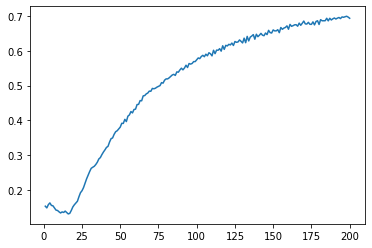

In [260]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = plt.axes()

x = np.linspace(1, 200, 200)
ax.plot(x, dev_uuas)

In [107]:
# _test_data_gpt = init_corpus_gpt(os.path.join('', 'data/en_ewt-ud-test.conllu'))
# _test_data_lstm = init_corpus_lstm(os.path.join('', 'data/en_ewt-ud-test.conllu'))

probe_gpt = torch.load("Tree_GPT.pt", map_location=torch.device('cpu'))
probe_lstm = torch.load("Tree_LSTM.pt", map_location=torch.device('cpu'))
probe_gpt.eval()
probe_lstm.eval()
test_loss, test_uuas_gpt = evaluate_probe(probe_gpt, _test_data_gpt)
test_loss, test_uuas_lstm = evaluate_probe(probe_lstm, _test_data_lstm)

print("The uuas score for the gpt model is", test_uuas_gpt)
print("The uuas score for the lstm model is", test_uuas_lstm)


The uuas score for the gpt model is 0.3054855743704838
The uuas score for the lstm model is 0.2379056119214695


## LaTeX trees

For your report you might want to add some of those fancy dependency tree plots like those of Figure 2 in the Structural Probing paper. For that you can use the following code, that outputs the corresponding LaTeX markup.

**N.B.**: for the latex tikz tree the first token in a sentence has index 1 (instead of 0), so take that into account with the predicted and gold edges that you pass to the method.

In [67]:
def print_tikz(predicted_edges, gold_edges, words):
    """ Turns edge sets on word (nodes) into tikz dependency LaTeX.
    Parameters
    ----------
    predicted_edges : Set[Tuple[int, int]]
        Set (or list) of edge tuples, as predicted by your probe.
    gold_edges : Set[Tuple[int, int]]
        Set (or list) of gold edge tuples, as obtained from the treebank.
    words : List[str]
        List of strings representing the tokens in the sentence.
    """

    string = """\\begin{dependency}[hide label, edge unit distance=.5ex]
    \\begin{deptext}[column sep=0.05cm]
    """

    string += (
        "\\& ".join([x.replace("$", "\$").replace("&", "+") for x in words])
        + " \\\\\n"
    )
    string += "\\end{deptext}" + "\n"
    for i_index, j_index in gold_edges:
        string += "\\depedge[-]{{{}}}{{{}}}{{{}}}\n".format(i_index, j_index, ".")
    for i_index, j_index in predicted_edges:
        string += f"\\depedge[-,edge style={{red!60!}}, edge below]{{{i_index}}}{{{j_index}}}{{.}}\n"
    string += "\\end{dependency}\n"
    print(string)

## Control tasks

Here we have the code to answer the research question: " Can the faithfulness of the probing results be validated, using control tasks?"

### POS Tags With Linear and Non-Linear Classifier

We first check this for the POS tagging.

In [182]:
# FETCH POS LABELS
import random

# Should return a tensor of shape (num_tokens_in_corpus,)
# Make sure that when fetching these pos tags for your train/dev/test corpora you share the label vocabulary.
def fetch_pos_tags_control(ud_parses: List[TokenList], pos_vocab=None) -> Tensor:
    pos_tags = list()
    if pos_vocab:
        pos_vocab = pos_vocab
    else:
        pos_vocab = dict()
    for sentence in ud_parses:
        for token in sentence:
            if str(token) in pos_vocab.keys():
                pos_tags.append(pos_vocab[str(token)])
            else:
                i = random.sample(range(17), 1)
                pos_vocab[str(token)] = i[0]
                pos_tags.append(i[0])

    pos_tags = torch.as_tensor(pos_tags)
  
    return pos_tags, pos_vocab

In [275]:
pos_tags_control = fetch_pos_tags_control(ud_parses)
print(torch.unique(pos_tags_control[0]))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])


In [184]:
import os

# Function that creates control labels for the POS tagging task. The x data to train on
# is the same as before

def create_pos_tags_control(filename: str, pos_vocab=None):
    ud_parses = parse_corpus(filename)
    
    pos_tags, pos_vocab = fetch_pos_tags_control(ud_parses, pos_vocab=pos_vocab)
    
    return pos_tags, pos_vocab


use_sample = True

train_y_control, train_vocab_control = create_pos_tags_control(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-train.conllu'),
)

dev_y_control, _ = create_pos_tags_control(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-dev.conllu'),
    pos_vocab=train_vocab_control
)

test_y_control, _ = create_pos_tags_control(
    os.path.join('data', 'sample' if use_sample else '', 'en_ewt-ud-test.conllu'),
    pos_vocab=train_vocab_control
)

Run these cells if you want to train the classiefier yourself

In [ ]:
classifier_control = pos_probe_linear(train_x, train_y_control, dev_x, dev_y_control)

In [ ]:
classifier_control.eval()
output_test_control = classifier_control(test_x)
test_acc_control = accuracy(output_test_control, test_y_control)
print("The test accuracy on the control task is",test_acc_control.item())

In [ ]:
non_linear_classifier = pos_probe_non_linear(train_x, train_y_control, dev_x, dev_y_control)

In [160]:
non_linear_classifier_control.eval()
non_linear_output_test_control = non_linear_classifier_control(test_x)
non_linear_test_acc_control = accuracy(non_linear_output_test_control, test_y_control)
print("The test accuracy on the control task for the non-linear classifier is",non_linear_test_acc_control.item())

And these cells are for when you already have pretrained models to load.

In [190]:
test_parses = parse_corpus('data/en_ewt-ud-test.conllu')
test_y_control = fetch_pos_tags_control(test_parses, pos_vocab=train_vocab_control)[0]
classifier_control = torch.load("linear_POS_GPT_control.pt", map_location=torch.device('cpu'))
classifier_control.eval()
output_test_control = classifier_control(test_x)
# output_test_control = torch.argmax(output_test_control, axis=1).unsqueeze(1)
print(output_test_control.shape, test_y_control.shape)
test_acc_control = accuracy(output_test_control, test_y_control)
print("The test accuracy on the control task is",test_acc_control.item())

torch.Size([25096, 17]) torch.Size([25096])
The test accuracy on the control task is 0.047378066927194595


In [191]:
non_linear_classifier_control = torch.load("non_linear_POS_GPT_control.pt", map_location=torch.device('cpu'))
non_linear_classifier_control.eval()
non_linear_output_test_control = non_linear_classifier_control(test_x)
print(non_linear_output_test_control.shape, test_y_control.shape)
# non_linear_output_test_control = torch.argmax(non_linear_output_test_control, axis=1).unsqueeze(1)
non_linear_test_acc_control = accuracy(non_linear_output_test_control, test_y_control)
print("The test accuracy on the control task is",non_linear_test_acc_control.item())

torch.Size([25096, 17]) torch.Size([25096])
The test accuracy on the control task is 0.053673893213272095


### Structural Probes

Now we check this for the strucural probe.

In [116]:
import random
from ete3 import Tree

def create_gold_distances_control(corpus):
    all_distances = []
    sen_length = [len(i) for i in corpus]
    max_length = max(sen_length)

    for item in (corpus):
        tokentree = item.to_tree()
        ete_tree = tokentree_to_ete(tokentree)

        sen_len = len(ete_tree.search_nodes())
        root = int(ete_tree.name)
        ete_tree = Tree()
        A = ete_tree.add_child(name=str(0))
        B = ete_tree.add_child(name=str(sen_len-1))
        distances = torch.full((max_length, max_length), -1)

        for i in range(1,sen_len-1):
            if i != root:
                choice = random.sample(range(3),1)
                if choice[0] == 0:
                    A.add_child(name=str(i))
                if choice[0] == 1:
                    B.add_child(name=str(i))
                if choice[0] == 2:
                    ete_tree.add_child(name=str(i))

        for i in range(sen_len):
            for j in range(sen_len):
                if i != root:
                    node_i = ete_tree&f"{i}"
                else:
                    node_i = ete_tree
                if j != root:
                    node_j = ete_tree&f"{j}"
                else:
                    node_j = ete_tree
                distances[i][j] = node_i.get_distance(node_j)

        all_distances.append(distances)

    return all_distances

In [360]:
gold_distance_control = create_gold_distances_control(corpus[5:6])[0]
print(gold_distance_control, '\n')
mst = create_mst(gold_distance_control)
print(mst)

tensor([[0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 2],
        [1, 0, 2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 3],
        [1, 2, 0, 4, 2, 2, 2, 4, 2, 2, 4, 2, 3],
        [3, 4, 4, 0, 4, 2, 4, 2, 4, 4, 2, 4, 1],
        [1, 2, 2, 4, 0, 2, 2, 4, 2, 2, 4, 2, 3],
        [1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1],
        [1, 2, 2, 4, 2, 2, 0, 4, 2, 2, 4, 2, 3],
        [3, 4, 4, 2, 4, 2, 4, 0, 4, 4, 2, 4, 1],
        [1, 2, 2, 4, 2, 2, 2, 4, 0, 2, 4, 2, 3],
        [1, 2, 2, 4, 2, 2, 2, 4, 2, 0, 4, 2, 3],
        [3, 4, 4, 2, 4, 2, 4, 2, 4, 4, 0, 4, 1],
        [1, 2, 2, 4, 2, 2, 2, 4, 2, 2, 4, 0, 3],
        [2, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 0]]) 

[[0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0

In [120]:
def init_corpus_control_gpt(path, concat=False, cutoff=None):
    """ Initialises the data of a corpus.
    
    Parameters
    ----------
    path : str
        Path to corpus location
    concat : bool, optional
        Optional toggle to concatenate all the tensors
        returned by `fetch_sen_reps`.
    cutoff : int, optional
        Optional integer to "cutoff" the data in the corpus.
        This allows only a subset to be used, alleviating 
        memory usage.
    """
    corpus = parse_corpus(path)[:cutoff]

    embs = fetch_sen_reps_tree(corpus, model, tokenizer, concat=concat)    
    gold_distances = torch.stack(create_gold_distances_control(corpus))
    
    return embs, gold_distances

def init_corpus_control_lstm(path, concat=False, cutoff=None):
    """ Initialises the data of a corpus.
    
    Parameters
    ----------
    path : str
        Path to corpus location
    concat : bool, optional
        Optional toggle to concatenate all the tensors
        returned by `fetch_sen_reps`.
    cutoff : int, optional
        Optional integer to "cutoff" the data in the corpus.
        This allows only a subset to be used, alleviating 
        memory usage.
    """
    corpus = parse_corpus(path)[:cutoff]

    embs = fetch_sen_reps_lstm_tree(corpus, lstm, vocab)    
    gold_distances = torch.stack(create_gold_distances_control(corpus))
    
    return embs, gold_distances

In [ ]:
import os

train_data = init_corpus_control_gpt(os.path.join('', 'data/en_ewt-ud-train.conllu'), cutoff=300)
_dev_data = init_corpus_control_gpt(os.path.join('', 'data/en_ewt-ud-train.conllu'), cutoff=100)
_test_data = init_corpus_control_gpt(os.path.join('', 'data/en_ewt-ud-train.conllu'), cutoff=100)

In [ ]:
dev_losses, dev_uuas, test_loss, test_uuas = train(train_data)
print(test_loss, test_uuas)

In [121]:
# _test_data_gpt_control = init_corpus_control_gpt(os.path.join('', 'data/en_ewt-ud-test.conllu'))
_test_data_lstm_control = init_corpus_control_lstm(os.path.join('', 'data/en_ewt-ud-test.conllu'))

probe_gpt_control = torch.load("Tree_GPT_control.pt", map_location=torch.device('cpu'))
probe_lstm_control = torch.load("Tree_LSTM_control.pt", map_location=torch.device('cpu'))
probe_gpt_control.eval()
probe_lstm_control.eval()
test_loss_control, test_uuas_gpt_control = evaluate_probe(probe_gpt_control, _test_data_gpt_control)
test_loss_control, test_uuas_lstm_control = evaluate_probe(probe_lstm_control, _test_data_lstm_control)

print("The uuas score for the gpt model is", test_uuas_gpt_control)
print("The uuas score for the lstm model is", test_uuas_lstm_control)


The uuas score for the gpt model is 0.2426014114122034
The uuas score for the lstm model is 0.2690943426395613
